In [1]:
import pandas as pd 
import numpy as np 
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from torchvision.io import read_image
import warnings
from transformers import DataCollatorWithPadding
import evaluate
import transformers
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset

/opt/anaconda3/envs/dnn-lectures/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Deep Neural Networks Laboratory

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We will load pre-trained BERT tokenizer and model from the Hugging Face Library.

In [3]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

/opt/anaconda3/envs/dnn-lectures/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Let's try tokenizing a dummy sentence.

In [4]:
dummy_sentence = "This is a laboratory session for the course of Deep Neural Networks"

In [5]:
inputs = tokenizer(dummy_sentence, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2023,  2003,  1037,  5911,  5219,  2005,  1996,  2607,  1997,
          2784, 15756,  6125,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The tokenizer returns 3 outputs: 
1. input_ids
2. token_type_ids
3. Attention_mask

We are interested in the input ids, which are the ids of the tokens in the vocabulary that BERT uses.

In [6]:
inputs['input_ids']

tensor([[  101,  2023,  2003,  1037,  5911,  5219,  2005,  1996,  2607,  1997,
          2784, 15756,  6125,   102]])

In [7]:
len(inputs['input_ids'][0])

14

In [8]:
len(dummy_sentence.split(" "))

12

We have more tokens than words in our sentence! That's because the BERT tokenizer adds the special tokens [CLS] and [SEP].

In [9]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]',
 'this',
 'is',
 'a',
 'laboratory',
 'session',
 'for',
 'the',
 'course',
 'of',
 'deep',
 'neural',
 'networks',
 '[SEP]']

In [10]:
dummy_sentence2 = "I am overjoyed!"

In [11]:
tokenizer.convert_ids_to_tokens(tokenizer(dummy_sentence2, return_tensors="pt")['input_ids'][0])

['[CLS]', 'i', 'am', 'over', '##joy', '##ed', '!', '[SEP]']

The tokenizer splits the tokens that are not directly part of its dictionary.

In this example, "overjoyed" was split into 3 separate tokens.

Let's go back to our previous sentence.

In [12]:
dummy_sentence = "This is a laboratory session for the course of Deep Neural Networks"

In [13]:
output = model(**tokenizer(dummy_sentence, return_tensors="pt"))

BERT returns an output made of the values in the last hidden state, and the pooled values.

In [14]:
output.last_hidden_state

tensor([[[-0.0926, -0.1325, -0.1644,  ..., -0.4650,  0.0330,  0.6237],
         [-0.3312, -0.7403, -0.3705,  ...,  0.2702,  0.2819,  0.1616],
         [-0.3973, -0.5434,  0.5455,  ...,  0.4126, -0.4199,  0.6934],
         ...,
         [ 0.9593,  0.2420,  0.3164,  ..., -0.2938, -0.6577, -0.4869],
         [ 0.0833, -0.4772, -0.0793,  ..., -0.4619, -0.2519,  0.7215],
         [ 0.7469, -0.0810, -0.3650,  ...,  0.1535, -0.9300, -0.1426]]],
       grad_fn=<NativeLayerNormBackward0>)

In [15]:
output.last_hidden_state.shape

torch.Size([1, 14, 768])

The shape is 1 (sentence) x 14 (tokens) x 768 (the output of BERT's embeddings).

768 will always be the output of BERT embeddings.

In [16]:
output.pooler_output.shape

torch.Size([1, 768])

The pooler output returns the hidden state of the first token of the last layer after further processing through the layers used for the auxiliary pretraining task. This is the token that is used as the input for the classification layer.

![images/BERT_classifier.png](images/BERT_classifier.png) 

The general BERT model only outputs embeddings. 

They can then be used in a variety of ways by fine-tuning for specific tasks.

Consider for instance the task of classification.

In [17]:
imdb = load_dataset("imdb")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

We create a preprocessing function and then use the "map" function from the datasets library to apply it to the whole dataset

In [19]:
def preprocess_function(examples):
    ## You can insert whatever preprocessing you prefer here
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [20]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

tokenized_imdb = tokenized_imdb.remove_columns(["text"])

tokenized_imdb.set_format("torch")


In [21]:
tokenized_imdb

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [22]:
unique_labels(imdb["test"]["label"])

array([0, 1])

In [23]:
from transformers import AutoModel

class CustomBERTModel(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        # Freeze BERT model parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  
        logits = self.classifier(pooled_output)
        return logits

base_model_name = "bert-base-uncased"
num_labels = len(set(imdb["test"]["label"]))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERTModel(base_model_name, num_labels).to(device)

/opt/anaconda3/envs/dnn-lectures/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
train_dataloader = DataLoader(tokenized_imdb["train"], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_imdb["test"], batch_size=16, collate_fn = data_collator)

In [27]:
#get first batch
batch = next(iter(train_dataloader))
batch

{'input_ids': tensor([[  101,  3841,  1037,  ...,     0,     0,     0],
        [  101,  2043,  1045,  ...,  2002,  2106,   102],
        [  101,  2025, 10261,  ...,     0,     0,     0],
        ...,
        [  101,  2023,  2001,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2023,  2143,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1])}

In [28]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Compute prediction and loss
        logits = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(batch_idx, loss.item())
            
        if batch_idx % 1000 == 0:
            loss_value = loss.item()
            current = (batch_idx + 1) * len(input_ids)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

    # Save the model
    torch.save({'model_weights': model.state_dict()}, 'model.pt')

# Define the testing loop
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask=attention_mask)
            test_loss += loss_fn(logits, labels).item()
            correct += (logits.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct)

In [29]:
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    i = 0
    total_batches = len(test_loader)

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item()
            if i % 100 == 0:
                print(f'Batch {i} out of {total_batches} done')
            i += 1

    print(f'Test loss: {total_loss/len(test_loader)} Test acc: {total_acc/len(tokenized_imdb["test"])*100}%')

In [30]:
train_dataloader

In [47]:
accuracies = []
net = model
losses = []
epochs = 1


for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, net, loss_fn, optimizer)
  accuracies.append(test_loop(test_dataloader, net, loss_fn))
print("Done!")

Epoch 1
-------------------------------
0 0.6558969020843506
loss: 0.655897  [   16/25000]
100 0.6164835095405579


KeyboardInterrupt: 

In [31]:
#save model
#torch.save(model.state_dict(), 'classifier_llm.pth')

In [38]:
#load model from file
#model = CustomBERTModel(base_model_name, num_labels).to(device)
model.load_state_dict(torch.load('classifier_llm.pth', map_location=torch.device('cpu')))
model.eval()

CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [65]:
evaluate(model, test_dataloader, nn.CrossEntropyLoss())

Batch 0 out of 1563 done
Batch 100 out of 1563 done
Batch 200 out of 1563 done
Batch 300 out of 1563 done
Batch 400 out of 1563 done
Batch 500 out of 1563 done
Batch 600 out of 1563 done
Batch 700 out of 1563 done
Batch 800 out of 1563 done
Batch 900 out of 1563 done
Batch 1000 out of 1563 done
Batch 1100 out of 1563 done
Batch 1200 out of 1563 done
Batch 1300 out of 1563 done
Batch 1400 out of 1563 done
Batch 1500 out of 1563 done
Test loss: 0.5954122509013668 Test acc: 72.336%


In [31]:
model.load_state_dict(torch.load('classifier_llm_10epochs.pth', map_location=torch.device('cpu')))
model.eval()

CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [32]:
evaluate(model, test_dataloader, nn.CrossEntropyLoss())

Batch 0 out of 1563 done
Batch 100 out of 1563 done
Batch 200 out of 1563 done
Batch 300 out of 1563 done
Batch 400 out of 1563 done
Batch 500 out of 1563 done
Batch 600 out of 1563 done
Batch 700 out of 1563 done
Batch 800 out of 1563 done
Batch 900 out of 1563 done
Batch 1000 out of 1563 done
Batch 1100 out of 1563 done
Batch 1200 out of 1563 done
Batch 1300 out of 1563 done
Batch 1400 out of 1563 done
Batch 1500 out of 1563 done
Test loss: 0.4397038208250426 Test acc: 80.676%


## Semantic Similarity

In [51]:
## you need to execute 
# pip install -U sentence-transformers
#to install the library

In [52]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
#embeddings = model.encode(sentences)

/opt/anaconda3/envs/dnn-lectures/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [66]:
sentence1 = "My dog is cute."
sentence2 = "My pet is adorable."
sentence3 = "The bank is closed."

output1 = model.encode(sentence1, convert_to_tensor=True)
output2 = model.encode(sentence2, convert_to_tensor=True)
output3 = model.encode(sentence3, convert_to_tensor=True)

In [67]:
torch.nn.functional.cosine_similarity(output1, output2, dim=0)

tensor(0.8552, device='mps:0')

In [68]:
torch.nn.functional.cosine_similarity(output2, output3, dim=0)

tensor(-0.0595, device='mps:0')

In [69]:
sentence1 = "I love the course of Deep Neural Networks at University of L\'Aquila and the laboratory sessions are especially interesting."

sentence2 = "My pet is adorable."
sentence3 = "I don't really like attending lectures at college."
sentence4 = "I love math and I love informatics and I love Artificial Intelligence and hands-on experience"

output1 = model.encode(sentence1, convert_to_tensor=True)
output2 = model.encode(sentence2, convert_to_tensor=True)
output3 = model.encode(sentence3, convert_to_tensor=True)
output4 = model.encode(sentence4, convert_to_tensor=True)

In [70]:
torch.nn.functional.cosine_similarity(output1, output2, dim=0)

tensor(0.0590, device='mps:0')

In [71]:
torch.nn.functional.cosine_similarity(output1, output3, dim=0)

tensor(0.3089, device='mps:0')

In [72]:
torch.nn.functional.cosine_similarity(output1, output4, dim=0)

tensor(0.4150, device='mps:0')

In [75]:
embeddings = [output1, output2, output3, output4]
#move embeddings to cpu
embeddings = [embedding.cpu().detach().numpy() for embedding in embeddings]

In [79]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)

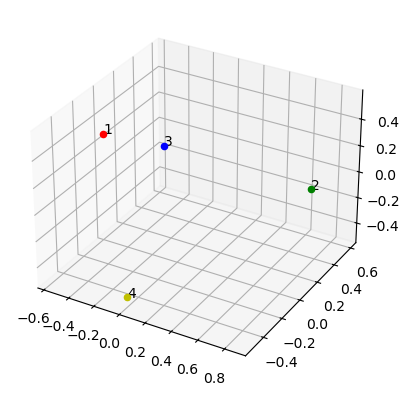

In [85]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y']
for i in range(4):
    ax.scatter(pca_embeddings[i][0], pca_embeddings[i][1], pca_embeddings[i][2], c=colors[i])
    ax.text(pca_embeddings[i][0], pca_embeddings[i][1], pca_embeddings[i][2], '%s' % (str(i+1)), size=10, zorder=1, color='k')

plt.show()